## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Opening JSON file
f = open('/content/gdrive/MyDrive/ML-Datasources/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
df.shape

(78313, 22)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
#print the column names
df.columns.values

array(['_index', '_type', '_id', '_score', '_source.tags',
       '_source.zip_code', '_source.complaint_id', '_source.issue',
       '_source.date_received', '_source.state',
       '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company',
       '_source.submitted_via', '_source.date_sent_to_company',
       '_source.company_public_response', '_source.sub_product',
       '_source.timely', '_source.complaint_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype=object)

In [ ]:
#Assign new column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'',
 '_source.complaint_id':'complaint_id',
 '_source.issue':'issue',
 '_source.date_received':'date_received',
 '_source.state':'state',
 '_source.consumer_disputed':'consumer_disputed',
 '_source.product':'product',
 '_source.company_response':'company_response',
 '_source.company':'company',
 '_source.submitted_via':'submitted_via',
 '_source.date_sent_to_company':'date_sent_to_company',
 '_source.company_public_response':'company_public_response',
 '_source.sub_product':'sub_product',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint_what_happened',
 '_source.sub_issue':'sub_issue',
 '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [ ]:
# Null values count after replacing blanks with nan
df['complaint_what_happened'].isnull().sum()

57241

In [ ]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text=text.lower()  #convert to lower case
  text=re.sub(r'^\[[\w\s]\]+$',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'^[a-zA-Z]\d+\w*$',' ',text) #Remove words with numbers
  return text

In [ ]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()
df_clean['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: clean_text(x)) # Changed progress_apply() to apply()
df_clean['complaint_what_happened_lemmatized'] = lemmatization(df_clean['complaint_what_happened'])

# adding category and sub_category columns to the dataframe for better topic identification
df_clean['category'] = df['product']
df_clean['sub_category'] = df['sub_product']

21072it [12:14, 28.68it/s]


In [ ]:
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple so...,Credit card or prepaid card,General-purpose credit card or charge card
78309,on wednesday xx xx xxxx i called chas my xxx...,wednesday xx xx xxxx call chas xxxx xxxx v...,Credit card or prepaid card,General-purpose credit card or charge card
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account,Checking account
78311,i have had flawless credit for 30 yrs i ve ha...,flawless credit 30 yrs ve chase credit card ...,Credit card or prepaid card,General-purpose credit card or charge card


In [ ]:
#Write your function to extract the POS tags
def pos_tag(text):
  pos_sentences = []
  for doc in tqdm(nlp.pipe(text)):
      sent = [token.text for token in doc if token.tag_ == 'NN']
      pos_sentences.append(' '.join(sent))
  return pos_sentences

df_clean["complaint_POS_removed"] = pos_tag(df_clean['complaint_what_happened_lemmatized']) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

21072it [05:55, 59.36it/s]


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple so...,Credit card or prepaid card,General-purpose credit card or charge card,chase card customer decade solicitation credit...
78309,on wednesday xx xx xxxx i called chas my xxx...,wednesday xx xx xxxx call chas xxxx xxxx v...,Credit card or prepaid card,General-purpose credit card or charge card,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account,Checking account,xxxx risk consumer chase year trust mobile ban...
78311,i have had flawless credit for 30 yrs i ve ha...,flawless credit 30 yrs ve chase credit card ...,Credit card or prepaid card,General-purpose credit card or charge card,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['complaint_what_happened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df_clean['complaint_what_happened_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

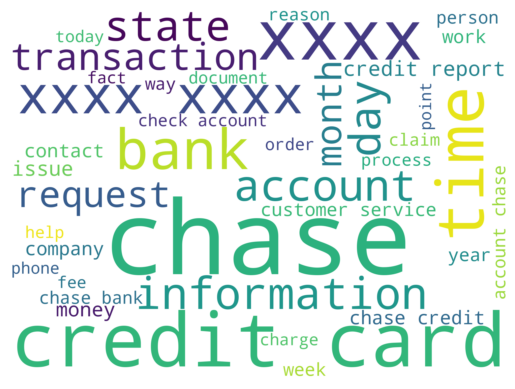

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
# function to get the specified top n-grams
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
unigram_30 = get_top_n_words(df_clean['Complaint_clean'], 1,30)
for word, freq in unigram_30:
    print(word, freq)

chase 58460
xxxx 52900
account 43065
credit 33912
card 30137
payment 21329
bank 19978
time 16233
charge 15387
day 13243
call 12225
money 11908
check 11229
loan 10671
report 10661
information 9605
letter 9468
state 9001
fee 8965
number 8656
month 8608
year 8428
contact 8151
customer 8139
transaction 8104
mortgage 7934
dispute 7852
pay 7754
service 7687
balance 7674


In [ ]:
#Print the top 10 words in the unigram frequency
unigram_10 = get_top_n_words(df_clean['Complaint_clean'], 1,10)
for word, freq in unigram_10:
    print(word)

chase
xxxx
account
credit
card
payment
bank
time
charge
day


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram_30 = get_top_n_words(df_clean['Complaint_clean'], 2,30)
for word, freq in bigram_30:
    print(word, freq)

credit card 12862
xxxx xxxx 6127
credit report 3927
chase credit 3170
customer service 3004
call chase 2956
chase bank 2579
account chase 2507
check account 2349
chase account 2114
contact chase 2073
xxxx chase 1950
debit card 1923
account xxxx 1871
bank account 1855
xxxx credit 1819
number xxxx 1765
credit score 1715
account account 1669
xxxx payment 1641
chase card 1625
payment xxxx 1558
card account 1528
card chase 1513
card xxxx 1328
interest rate 1300
chase xxxx 1290
phone number 1244
letter chase 1239
business day 1231


In [ ]:
#Print the top 10 words in the bigram frequency
bigram_10 = get_top_n_words(df_clean['Complaint_clean'], 2,10)
for word, freq in bigram_10:
    print(word)

credit card
xxxx xxxx
credit report
chase credit
customer service
call chase
chase bank
account chase
check account
chase account


In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram_30 = get_top_n_words(df_clean['Complaint_clean'], 3,30)
for word, freq in trigram_30:
    print(word, freq)

chase credit card 2275
xxxx xxxx xxxx 1713
credit card account 1061
credit card company 977
xxxx credit card 825
credit card chase 762
chase customer service 579
credit card xxxx 550
inquiry credit report 472
credit card credit 411
charge credit card 397
credit reporting agency 387
account credit card 345
call customer service 328
credit reporting act 312
customer service representative 302
credit report credit 302
card credit card 301
chase checking account 296
credit card payment 291
chase auto finance 290
credit card charge 288
payment xxxx payment 284
chase card service 283
account number xxxx 283
bank credit card 261
xxxx payment xxxx 255
account call chase 245
credit card balance 240
victim identity theft 235


In [ ]:
#Print the top 10 words in the trigram frequency
trigram_10 = get_top_n_words(df_clean['Complaint_clean'], 3,10)
for word, freq in trigram_10:
    print(word)

chase credit card
xxxx xxxx xxxx
credit card account
credit card company
xxxx credit card
credit card chase
chase customer service
credit card xxxx
inquiry credit report
credit card credit


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...
...,...,...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple so...,Credit card or prepaid card,General-purpose credit card or charge card,chase card customer decade solicitation credit...,679,420,259,chase card customer decade solicitation credit...
78309,on wednesday xx xx xxxx i called chas my xxx...,wednesday xx xx xxxx call chas xxxx xxxx v...,Credit card or prepaid card,General-purpose credit card or charge card,credit card provider claim purchase protection...,2114,1237,707,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account,Checking account,xxxx risk consumer chase year trust mobile ban...,2319,1382,704,risk consumer chase year trust mobile banking...
78311,i have had flawless credit for 30 yrs i ve ha...,flawless credit 30 yrs ve chase credit card ...,Credit card or prepaid card,General-purpose credit card or charge card,credit yrs credit card chase freedom xxxx prob...,2171,1355,520,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer
tf_idf_vec=TfidfVectorizer(max_df=0.98,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf=tf_idf_vec.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [ ]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out())

6257

In [ ]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['service', 'time', 'reason', 'application', 'month', 'point', 'purchase', 'year', 'limit', 'score', 'account', 'balance', 'chase', 'credit', 'card']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['date', 'statement', 'balance', 'property', 'rate', 'pay', 'year', 'time', 'home', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['dispute', 'letter', 'score', 'theft', 'remove', 'file', 'identity', 'account', 'reporting', 'debt', 'information', 'company', 'credit', 'inquiry', 'report']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['statement', 'time', 'email', 'contact', 'service', 'fraud', 'purchase', 'refund', 'claim', 'merchant', 'transaction', 'chase', 'fee', 'disp

In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([0, 1, 3, ..., 3, 1, 2])

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_values.argmax(axis=1) #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...,3
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...,3
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values(by='Topic')

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0
17,with out notice j p morgan chase restricted m...,notice j p morgan chase restrict account deb...,Checking or savings account,Checking account,account debit card branch customer service rep...,2277,1315,638,account debit card branch customer service rep...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,Vehicle loan or lease,Loan,mishandle account chase auto xxxx,51,33,33,mishandle account chase auto,0
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus ...,Checking or savings account,Checking account,account call follow term account xxxx deposit ...,413,202,102,account call follow term account deposit bonu...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,Credit card or prepaid card,General-purpose credit card or charge card,catering order place contact chase noon today ...,1972,1125,573,catering order place contact chase noon today ...,1
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,Checking or savings account,Checking account,roommate chase debit card driver license money...,843,556,210,roommate chase debit card driver license money...,1
50,i am a senior citizen that has been scammed by...,senior citizen scamme company xxxx xxxx pay ...,Credit card or prepaid card,General-purpose credit card or charge card,citizen time share company refund credit card ...,350,153,65,citizen time share company refund credit card ...,1
59,i currently have over xxxx chase ultimate rewa...,currently xxxx chase ultimate reward point w...,Credit card or prepaid card,General-purpose credit card or charge card,xxxx reward point month access chase reward ac...,1897,1155,551,reward point month access chase reward accoun...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic,Topic_category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1,Credit card or prepaid card
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...,3,Theft/Dispute Reporting
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...,3,Theft/Dispute Reporting
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [ ]:
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,1
10,chase card was reported on xx xx 2019 however...,3
11,on xx xx 2018 while trying to book a xxxx xx...,3
14,my grand son give me check for 1600 00 i de...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
count_vect=CountVectorizer()

#Write your code to get the Vector count
X_train_counts=count_vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
# Checking for class imbalance
px.bar(x=training_data['Topic'].value_counts().index, y=training_data['Topic'].value_counts().values/max(training_data['Topic'].value_counts().values), title='Class Imbalance')

**As class imbalace is present in the data, but is not very severe, we will not be using any sampling techniques to balance the data. We will be using F1 score as the evaluation metric for the models and stratified k-fold cross validation to evaluate the models.**

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
# Prepare the training and test data
train_X, test_X, train_y, test_y = train_test_split(X_train_tf, training_data['Topic'], test_size=0.2, random_state=40)

In [ ]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(16857, 29725)
(4215, 29725)
(16857,)
(4215,)


In [ ]:
# function to evaluate the model and display the results
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', accuracy_score(y_test,y_pred).round(2))
    print('Precision: ', precision_score(y_test,y_pred,average='weighted').round(2))
    print('Recall: ', recall_score(y_test,y_pred,average='weighted').round(2))
    print('F1 Score: ', f1_score(y_test,y_pred,average='weighted').round(2))
    print('ROC AUC Score: ', roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr').round(2))
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()

In [ ]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid={},cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1)
    grid.fit(train_X,train_y)
    return grid.best_estimator_

**1. Logistic Regression**

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training results
Accuracy:  0.96
Precision:  0.96
Recall:  0.96
F1 Score:  0.96
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.96      0.98      0.97      4164
           1       0.97      0.96      0.97      3131
           2       0.97      0.98      0.97      4077
           3       0.97      0.93      0.95      1871
           4       0.96      0.95      0.96      3614

    accuracy                           0.96     16857
   macro avg       0.96      0.96      0.96     16857
weighted avg       0.96      0.96      0.96     16857

Test results
Accuracy:  0.91
Precision:  0.91
Recall:  0.91
F1 Score:  0.91
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.91      0.95      0.93      1032
           1       0.92      0.90      0.91       778
           2       0.92      0.95      0.94      1009
           3       0.93      0.87      0.90      

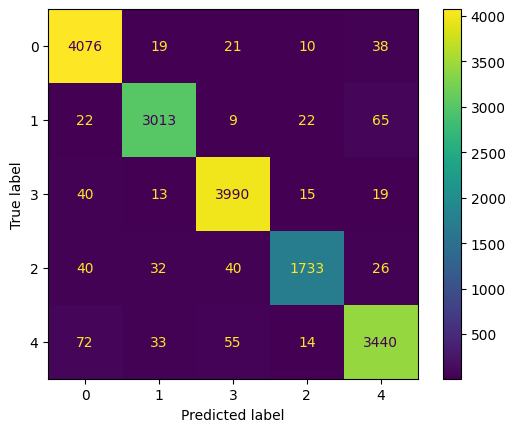

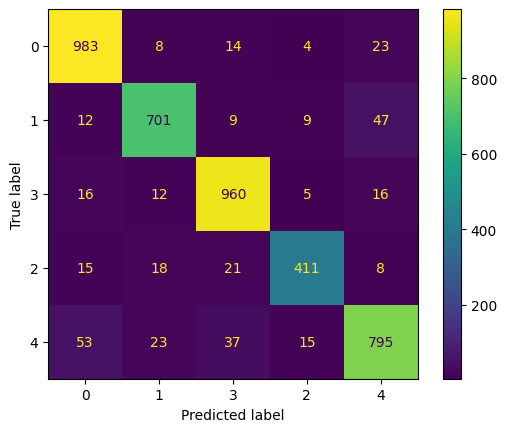

In [ ]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [None, 'balanced']
}
model_lr=run_model(LogisticRegression(),params)
eval_model(train_y,model_lr.predict(train_X),model_lr.predict_proba(train_X),type='Training')
eval_model(test_y,model_lr.predict(test_X),model_lr.predict_proba(test_X),type='Test')

**2. Decision Tree**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      4164
           1       1.00      1.00      1.00      3131
           2       1.00      1.00      1.00      4077
           3       1.00      1.00      1.00      1871
           4       1.00      1.00      1.00      3614

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

Test results
Accuracy:  0.76
Precision:  0.76
Recall:  0.76
F1 Score:  0.76
ROC AUC Score:  0.85
Classification Report:                precision    recall  f1-score   support

           0       0.77      0.77      0.77      1032
           1       0.78      0.78      0.78       778
           2       0.80      0.81      0.81     

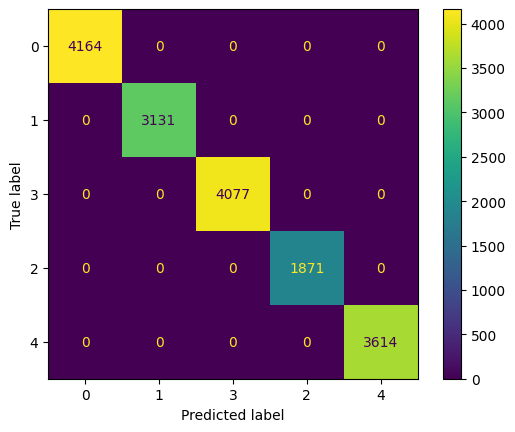

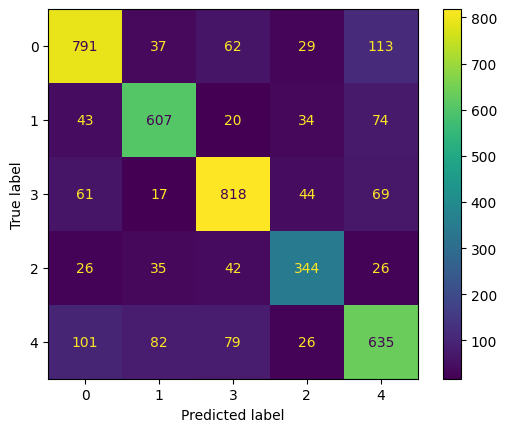

In [ ]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
model_dt=run_model(DecisionTreeClassifier(),params)
eval_model(train_y,model_dt.predict(train_X),model_dt.predict_proba(train_X),type='Training')
eval_model(test_y,model_dt.predict(test_X),model_dt.predict_proba(test_X),type='Test')

**3. Random Forest**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      4164
           1       1.00      1.00      1.00      3131
           2       1.00      1.00      1.00      4077
           3       1.00      1.00      1.00      1871
           4       1.00      1.00      1.00      3614

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

Test results
Accuracy:  0.82
Precision:  0.82
Recall:  0.82
F1 Score:  0.82
ROC AUC Score:  0.97
Classification Report:                precision    recall  f1-score   support

           0       0.79      0.93      0.85      1032
           1       0.81      0.75      0.78       778
           2       0.85      0.90      0.87     

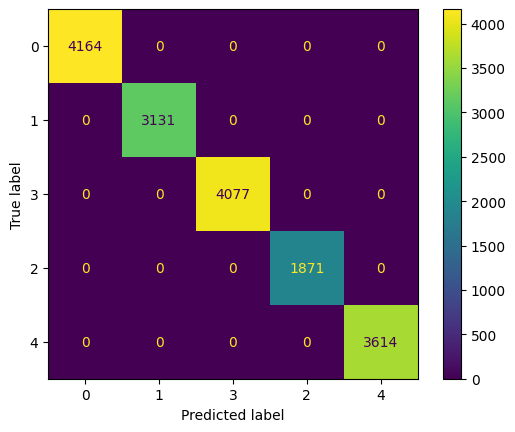

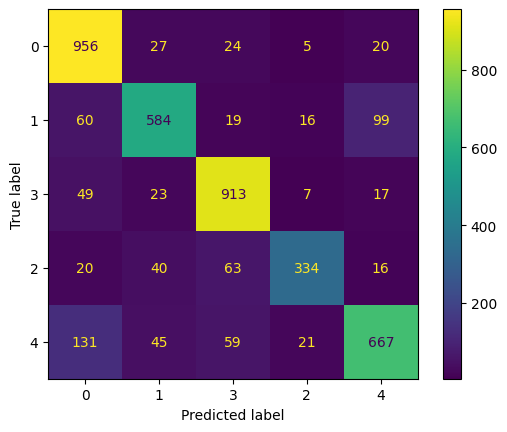

In [ ]:
#running and evaluating the Random Forest model
params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
model_rf=run_model(RandomForestClassifier(),params)
eval_model(train_y,model_rf.predict(train_X),model_rf.predict_proba(train_X),type='Training')
eval_model(test_y,model_rf.predict(test_X),model_rf.predict_proba(test_X),type='Test')

**4. Multinomial Naive Bayes**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training results
Accuracy:  0.74
Precision:  0.77
Recall:  0.74
F1 Score:  0.72
ROC AUC Score:  0.96
Classification Report:                precision    recall  f1-score   support

           0       0.66      0.95      0.78      4164
           1       0.84      0.49      0.62      3131
           2       0.71      0.91      0.80      4077
           3       0.96      0.30      0.46      1871
           4       0.80      0.73      0.77      3614

    accuracy                           0.74     16857
   macro avg       0.80      0.68      0.68     16857
weighted avg       0.77      0.74      0.72     16857

Test results
Accuracy:  0.69
Precision:  0.73
Recall:  0.69
F1 Score:  0.66
ROC AUC Score:  0.94
Classification Report:                precision    recall  f1-score   support

           0       0.63      0.94      0.76      1032
           1       0.78      0.40      0.53       778
           2       0.68      0.89      0.77

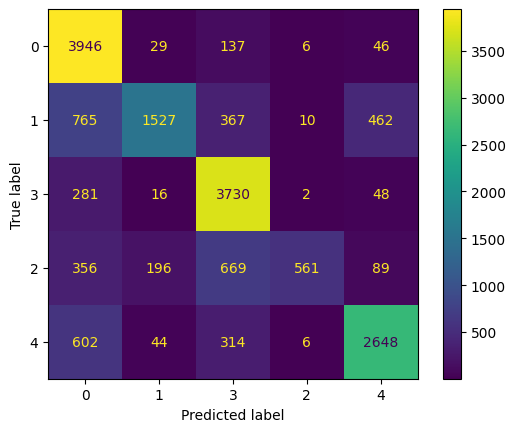

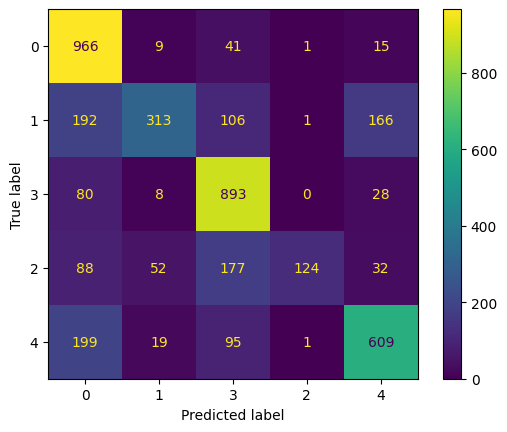

In [ ]:
#running and evaluating the Gaussian Naive Bayes model
params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}
model_nb=run_model(MultinomialNB(),params)
eval_model(train_y,model_nb.predict(train_X),model_nb.predict_proba(train_X),type='Training')
eval_model(test_y,model_nb.predict(test_X),model_nb.predict_proba(test_X),type='Test')

## Final Results

| Model | Accuracy | Precision | Recall | F1 Score | ROC AUC Score |
| ----- | -------- | --------- | ------ | -------- | ------------- |
| Logistic Regression |	0.91 |	0.91 |	0.91 |	0.91 |	0.99 |
| DecisionTreeClassifier |	0.76 |	0.76 |	0.76 |	0.76 |	0.85 |
| RandomForestClassifier |	0.82 |	0.83 |	0.82 |	0.81 |	0.97 |
| MultinomialNB |	0.69 |	0.73 |	0.69 |	0.66 |	0.94 |

# Conclusion

As from the results we can see that Logistic Regression is performing the best with an F1 score of 0.91. So we ill be using this model to predict the topics for the new complaints.

In [ ]:
# Applying the best model on the Custom Text
# We will use the Logistic Regression as it has the best performance
df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})

In [ ]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = model_lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [ ]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Account Services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Account Services
5,I need to know the number of bank branches and...,Account Services
